## LETK Filtering


In [1]:
import Simulator
import Observation
import Statistics
import LETKalmanFilter

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [2]:
timestamp = "2021_08_10-09_34_31"

grid, simulator = Simulator.from_file(timestamp)

## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [3]:
statistics = Statistics.Statistics(simulator, N_e=100)

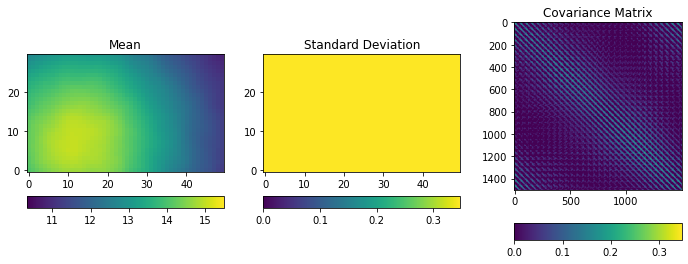

In [4]:
prior_args = Statistics.prior_args_from_file(timestamp)
statistics.set_prior(prior_args)

statistics.plot()

### Observations

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [5]:
obs_timestamp = "2021_08_10-09_34_39"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


### Observation Grouping Preparation 

In [6]:
import numpy as np

In [7]:
obs_poses = observation.positions * np.array([grid.dx, grid.dy])
obs_poses

array([[0., 0.],
       [1., 0.],
       [2., 0.],
       [3., 0.],
       [4., 0.],
       [0., 1.],
       [1., 1.],
       [2., 1.],
       [3., 1.],
       [4., 1.],
       [0., 2.],
       [1., 2.],
       [2., 2.],
       [3., 2.],
       [4., 2.]])

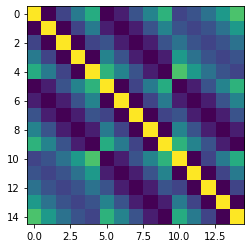

In [8]:
obs_dist_mat = np.eye(observation.N_y)
for i in range(observation.N_y):
    obs_dist_mat[i,:] = np.linalg.norm(obs_poses - obs_poses[i], axis=1)
np.fill_diagonal(obs_dist_mat, np.sqrt(grid.xdim**2 + grid.ydim**2))

from matplotlib import pyplot as plt
plt.imshow(obs_dist_mat)

In [9]:
groups = list([list(np.arange(observation.N_y, dtype=int))])
groups

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]

In [10]:
obs_dist_mat[np.ix_(groups[0],groups[0])].shape

(15, 15)

In [11]:
groups[0] = list(np.delete(groups[0], np.where(groups[0] == 5)))
groups

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]

## LETKF filtering

Updating/conditioning the distributions at every observation time

In [12]:
letkFilter = LETKalmanFilter.LETKalman(statistics, observation, 5)

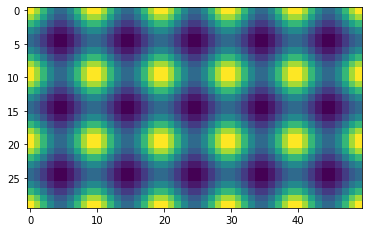

In [13]:
from matplotlib import pyplot as plt
plt.imshow(letkFilter.W_analysis)

In [ ]:
statistics.propagate(25)

0


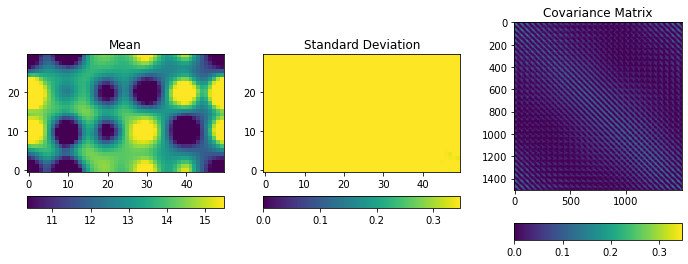

1


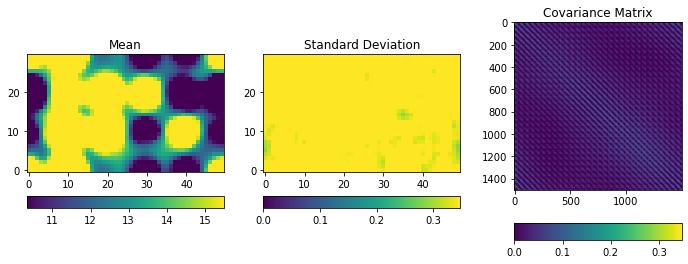

2


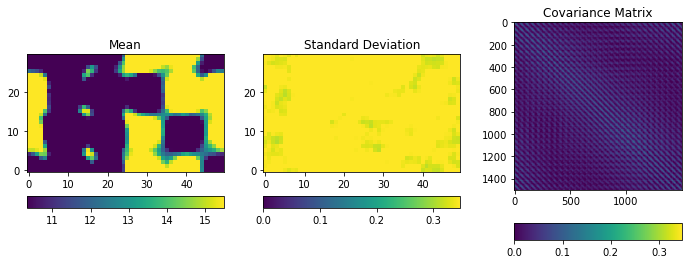

3


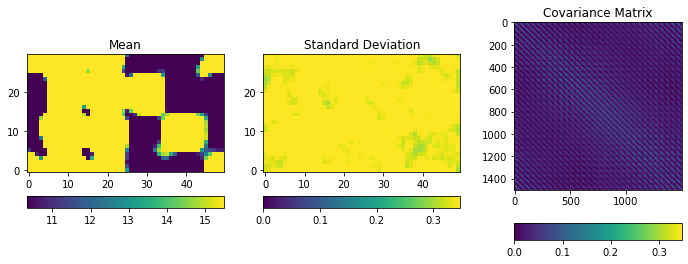

4


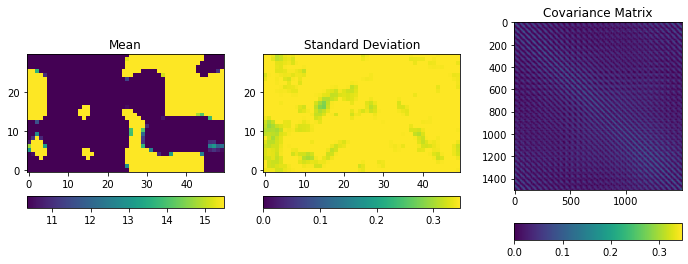

5


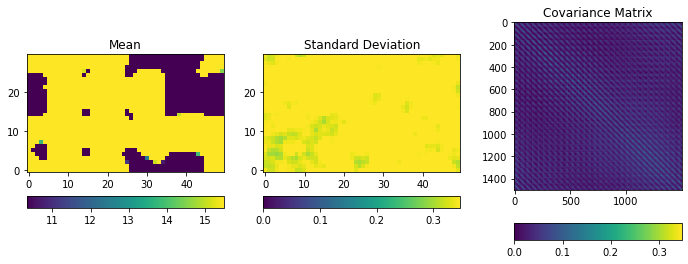

6


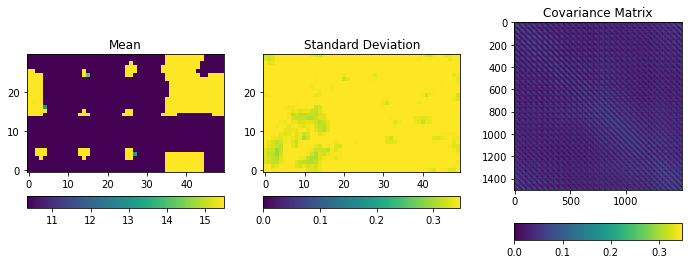

7


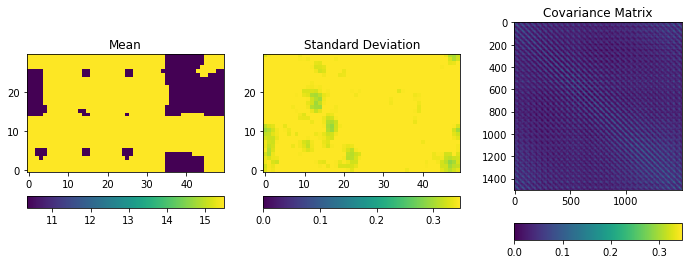

8


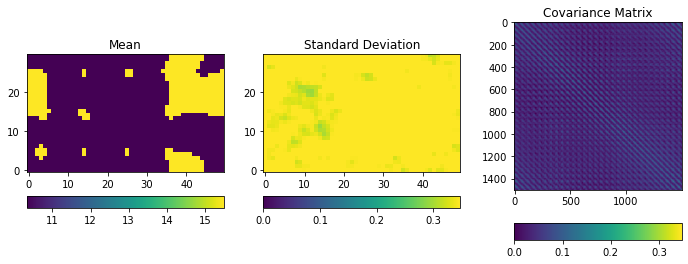

9


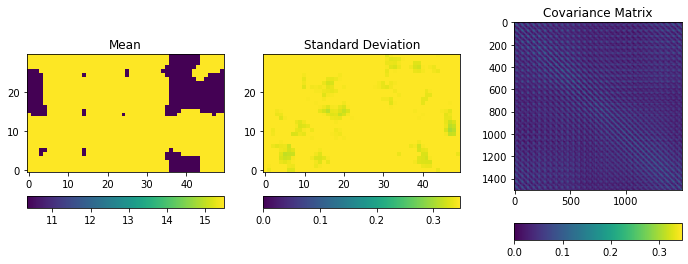

In [14]:
for t in range(observation.N_obs):
    print(t)
    statistics.propagate(25)
    letkFilter.filter(statistics.ensemble.ensemble, observation.obses[t])
    statistics.plot()